# DataCleaning Notebook - AAAG

In [1]:
# Basics Importation 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

# For Detailed Stats Output
import statsmodels.api as sm
# The linear regression models 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoCV, ElasticNetCV
# Instantiating the linear regression models
ols = LinearRegression()
ridge = Ridge()
lasso  = Lasso()
lassocv = LassoCV()
elasticnet = ElasticNet()
elasticnetcv = ElasticNetCV()
# The tree model
from sklearn import tree
# Instantiating the tree model (regression type)
regressor = tree.DecisionTreeRegressor()
# The ensemble model for random forest and bagging
from sklearn import ensemble
# Instantiating the ensemble models
randomForest = ensemble.RandomForestRegressor()
bagging      = ensemble.BaggingRegressor()
# Instantiating the boost models
gbm          = ensemble.GradientBoostingRegressor()
abr          = ensemble.AdaBoostRegressor()
# xg boost
import xgboost as xgb
# lg boost
import lightgbm as lgb
# K mean clustering
from sklearn.cluster import KMeans
kmeans = KMeans()
# The model selection for cross validation, k fold splits, train_test_split, grid search etc. 
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# Some automatic feature selection functions (recursive finding, best feature selection etc.)
import sklearn.feature_selection as fs
# Importing the different error evaluation/metrics
from sklearn import metrics
from sklearn.metrics import silhouette_score

# Making it so that we can see all columns of the dataframe
pd.set_option('display.max_columns', None)

In [2]:
df_train = pd.read_csv('train.csv',index_col ="Id")
# logging the SalePrice
df_train.SalePrice = np.log1p(df_train.SalePrice)
df_test = pd.read_csv('test.csv',index_col ="Id")
df_total = pd.concat([df_train,df_test],axis=0,sort=False)

In [3]:
# Check if columns are common
set(df_test.columns)==set(df_train.drop('SalePrice',axis=1).columns)

True

In [4]:
def missingValuesInfo(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100, 2)
    temp = pd.concat([total, percent], axis = 1,keys= ['Total', 'Percent'])
    return temp.loc[(temp['Total'] > 0)]
missingValuesInfo(df_total)

,Total,Percent
PoolQC,2909,99.66
MiscFeature,2814,96.40
Alley,2721,93.22
Fence,2348,80.44
SalePrice,1459,49.98
FireplaceQu,1420,48.65
LotFrontage,486,16.65
GarageCond,159,5.45
GarageYrBlt,159,5.45
GarageQual,159,5.45


In [5]:
def my_impute(df_col,method='replace',replace_with=None,missing_string=None,convert_to_numeric='infer'):
    '''
    - This function takes works for the columns mentioned above. 
    - df_col: take a column series 
    - replace: replace a null with a string defined by replace_with
    - replace_with: the string that replaces the null value
    - missing_string: define what constitutes a null value which will be replaced
    - convert_to_numeric: takes in "infer", "force", "no". "Infer" automatically senses what is 
    - the best action. Converts variable type to numeric. 
    '''
    new_series=df_col.copy()
    try:
        if (df_col.str.contains('Shed').any() and df_col.str.contains('TenC').any()):
            misc_dict={'Gar2':'Shed',
                      'Othr':'No Shed',
                      'TenC':'No Shed'}
            new_series.replace(misc_dict,inplace=True)
        if missing_string!=None:
            missing_dict={null_word:None for i in missing_string}
            new_series.replace(missing_dict,inplace=True) 
        if method=='replace':
            if replace_with==None:
                raise ValueError('Must provide replacement string!')
            new_series[new_series.isnull()]=replace_with
        elif method=='mode':
            new_series[new_series.isnull()]=new_series.mode(dropna=True)[0]
        if convert_to_numeric=='force': 
            score_dict={'TA':3,
                       'Gd':4,
                       'Ex':5,
                       'Fa':2,
                       'Po':1,
                       replace_with:np.nan}
            new_series.replace(score_dict,inplace=True)
            if method=='mean':
                new_series[new_series.isnull()]=new_series.mean(skipna=True)
            else:
                new_series.fillna(0)
            return new_series
        elif convert_to_numeric=='infer':
            if new_series.str.contains('(^Gd$)',regex=True).any() and \
                new_series.str.contains('(^TA$)',regex=True).any() and \
                new_series.str.contains('(^Fa$)',regex=True).any():
                score_dict={'TA':3,
                           'Gd':4,
                           'Ex':5,
                           'Fa':2,
                           'Po':1,
                           replace_with:np.nan}
                new_series.replace(score_dict,inplace=True)
                if method=='mean':
                    new_series[new_series.isnull()]=new_series.mean(skipna=True)
                else:
                    new_series.fillna(0)
                return new_series
            elif new_series.str.contains('(^Gd$)',regex=True).any() and \
                new_series.str.contains('(^Av$)',regex=True).any() and \
                new_series.str.contains('(^Mn$)',regex=True).any() and \
                new_series.str.contains('(^No$)',regex=True).any():
                score_dict={'Gd':4,
                           'Av':3,
                           'Mn':2,
                           'No':1,
                           replace_with:np.nan}
                new_series.replace(score_dict,inplace=True)
                if method=='mean':
                    new_series[new_series.isnull()]=new_series.mean(skipna=True)
                else:
                    new_series.fillna(0)
                return new_series
            else:
                return new_series
        elif convert_to_numeric=='no':
            return new_series
        else:
            return new_series
    except:
        try: 
            if method=='mean':
                new_series[new_series.isnull()]=new_series.mean(skipna=True)
                return new_series
            elif method=='median':
                new_series[new_series.isnull()]=new_series.median(skipna=True)[0]
                return new_series
        except Exception as e:
            print(type(e),e)

In [6]:
nominal_var_processed=['MSZoning','Street','Alley','LotShape','LandContour','LotConfig','LandSlope',\
             'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl',\
             'Exterior1st','Exterior2nd','MasVnrType','Foundation',\
             'BsmtFinType1','Heating','CentralAir',\
             'Electrical','Functional','GarageType','GarageFinish',\
             'PavedDrive','Fence','MiscFeature','SaleType','SaleCondition','MSSubClass',\
             'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MoSold']
ordinal_var_processed=['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath',\
             'HalfBath','BedroomAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars',\
             'YrSold','HeatingQC','KitchenQual','ExterQual','ExterCond','BsmtQual',\
             'BsmtCond','BsmtExposure','FireplaceQu','GarageQual','GarageCond']
cont_var_processed=['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','TotalBsmtSF',\
          '1stFlrSF','2ndFlrSF','GrLivArea','GarageYrBlt','GarageArea']
cont_var_for_tuning=ordinal_var_processed+cont_var_processed

In [7]:
def ultimate_clean(df):
    # Clean:          
    # - PavedDrive
    # - SaleCondition
    # - SaleType
    # - Street
    # - Central Air
    # - Heating
    # - 1stFlrSF
    # - 2ndFlrSF
    # - GrLivArea
    # - LotArea
    # - MSZone
    # - OverallCond
    # - OverallQual
    # - TotalBsmtSF
    # - YearBuilt
    # - YearRemodAdd

    # Drop
    # - PoolQC
    # - BsmtFinType2
    # - Utilities
    # - BsmtFinSF1  
    # - BsmtFinSF2  
    # - BsmtUnSF 
    # - LowQualFinSF
    # - KitchenAbvGr 
    # - MiscVal 
    df = df.drop(['PoolQC','BsmtFinType2','Utilities',\
                              'BsmtFinSF1', 'BsmtFinSF2',\
                              'BsmtUnfSF','LowQualFinSF','KitchenAbvGr', 'MiscVal'], axis=1)

    # apply the make binary function to the porch, deck, and pool variables (MUTATING!)
    vrs = ['3SsnPorch', 'EnclosedPorch', 'OpenPorchSF','PoolArea','ScreenPorch', 'WoodDeckSF']
    for col in vrs:
        df.loc[:,col]=df.loc[:,col].apply(lambda x: 1 if (x>0) else 0)
    
    # Converting to category/string
    # - MSSubClass
    # - MoSold
    df['MSSubClass'] = df['MSSubClass'].astype('category')
    df['MoSold'] = df['MoSold'].astype('category')

    # Impute with mode/median
    # - Electrical 
    # - MSZoning
    # - Exterior1st
    # - Exterior2nd
    # - SaleType
    df.loc[:,'Electrical']=my_impute(df.loc[:,'Electrical'],method='mode',replace_with=None,missing_string=None,convert_to_numeric='no')
    df.loc[:,'MSZoning']=my_impute(df.loc[:,'MSZoning'],method='mode',replace_with=None,missing_string=None,convert_to_numeric='no')
    df.loc[:,'Exterior1st']=my_impute(df.loc[:,'Exterior1st'],method='mode',replace_with=None,missing_string=None,convert_to_numeric='no')
    df.loc[:,'Exterior2nd']=my_impute(df.loc[:,'Exterior2nd'],method='mode',replace_with=None,missing_string=None,convert_to_numeric='no')
    df.loc[:,'SaleType']=my_impute(df.loc[:,'SaleType'],method='mode',replace_with=None,missing_string=None,convert_to_numeric='no')

    # Impute with mean 
    # - GarageYrBlt
    df.loc[:,'GarageYrBlt']=my_impute(df.loc[:,'GarageYrBlt'],method='mean',replace_with=None,missing_string=None,convert_to_numeric='no')

    # Impute with groupedby median of neighborhood
    # - LotFrontage
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # Replace with N/A with “no fence”, "No Alley" "No Basement" etc.
    # - Fence
    # - Alley
    # - GarageFinish
    # - GarageType
    # - BsmtFinType1
    df.loc[:,'Fence']=my_impute(df.loc[:,'Fence'],method='replace',replace_with='No Fence',missing_string=None,convert_to_numeric='infer')
    df.loc[:,'Alley']=my_impute(df.loc[:,'Alley'],method='replace',replace_with='No Alley',missing_string=None,convert_to_numeric='infer')
    df.loc[:,'GarageFinish']=my_impute(df.loc[:,'GarageFinish'],method='replace',replace_with='No Garage',missing_string=None,convert_to_numeric='infer')
    df.loc[:,'GarageType']=my_impute(df.loc[:,'GarageType'],method='replace',replace_with='No Garage',missing_string=None,convert_to_numeric='infer')
    df.loc[:,'BsmtFinType1']=my_impute(df.loc[:,'BsmtFinType1'],method='replace',replace_with='No Basement',missing_string=None,convert_to_numeric='infer')
    df.loc[:,'MasVnrType']=my_impute(df.loc[:,'MasVnrType'],method='replace',replace_with='No Masonry Veneer',missing_string=None,convert_to_numeric='no')

    # Replace with N/A with mean and turning ordinal into continuous variable
    # - BsmtCond
    # - BsmtExposure
    # - BsmtQual
    # - GarageCond
    # - GarageQual
    # - FireplaceQu
    # - HeatingQC
    # - KitchenQual
    df.loc[:,'BsmtCond']=my_impute(df.loc[:,'BsmtCond'],method='mean',replace_with=0,missing_string=None,convert_to_numeric='infer')
    df.loc[:,'BsmtExposure']=my_impute(df.loc[:,'BsmtExposure'],method='mean',replace_with=0,missing_string=None,convert_to_numeric='infer')
    df.loc[:,'BsmtQual']=my_impute(df.loc[:,'BsmtQual'],method='mean',replace_with=0,missing_string=None,convert_to_numeric='infer')
    df.loc[:,'GarageCond']=my_impute(df.loc[:,'GarageCond'],method='mean',replace_with=0,missing_string=None,convert_to_numeric='infer')
    df.loc[:,'GarageQual']=my_impute(df.loc[:,'GarageQual'],method='mean',replace_with=0,missing_string=None,convert_to_numeric='infer')
    df.loc[:,'FireplaceQu']=my_impute(df.loc[:,'FireplaceQu'],method='mean',replace_with=0,missing_string=None,convert_to_numeric='infer')
    df.loc[:,'HeatingQC']=my_impute(df.loc[:,'HeatingQC'],method='mean',replace_with=0,missing_string=None,convert_to_numeric='infer')
    df.loc[:,'KitchenQual']=my_impute(df.loc[:,'KitchenQual'],method='mean',replace_with=0,missing_string=None,convert_to_numeric='infer')
    df.loc[:,'ExterCond']=my_impute(df.loc[:,'ExterCond'],method='mean',replace_with=0,missing_string=None,convert_to_numeric='infer')
    df.loc[:,'ExterQual']=my_impute(df.loc[:,'ExterQual'],method='mean',replace_with=0,missing_string=None,convert_to_numeric='infer')

    # Replace with N/A with 0 only
    # - MasVnrArea
    # - GarageArea
    # - GarageCars
    # - BsmtFullBath
    # - BsmtHalfBath
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
    df['GarageArea'] = df['GarageArea'].fillna(0)
    df['GarageCars'] = df['GarageCars'].fillna(0)
    df['BsmtFullBath'] = df['BsmtFullBath'].fillna(0)
    df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(0)
    df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(0) # This one doesn't matter because there is no basement

    # Replace with N/A with 'Typ' only
    # - Functional
    df['Functional'] = df['Functional'].fillna('Typ')

    # Lumping features into shed and no shed
    # - MiscFeature
    df.loc[:,'MiscFeature']=my_impute(df.loc[:,'MiscFeature'],method='replace',replace_with='No Shed',missing_string=None,convert_to_numeric='infer')
    return(df)

In [8]:
df_train_cleaned = ultimate_clean(df_train)
df_test_cleaned = ultimate_clean(df_test)
df_total_cleaned = ultimate_clean(df_total)
# Check: 
df_test_cleaned.isnull().sum().sum()
missingValuesInfo(df_test_cleaned)

/home/auscheng/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,Total,Percent


(0, 5000)

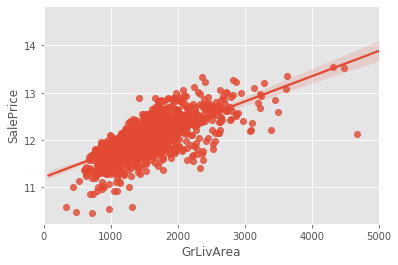

In [9]:
sns.regplot(x='GrLivArea',y='SalePrice',data=df_train_cleaned)
plt.xlim(0,5000)

In [10]:
# Remove outliers based on physical inspection
df_train_cleaned.drop(df_train_cleaned[(df_train_cleaned['OverallQual']<5)& (df_train_cleaned['SalePrice']>np.log1p(200000))].index, inplace = True)
df_train_cleaned.drop(df_train_cleaned[(df_train_cleaned['GrLivArea']>4500)& (df_train_cleaned['SalePrice']<np.log1p(300000))].index, inplace = True)
df_total_cleaned.drop(df_total_cleaned[(df_total_cleaned['OverallQual']<5)& (df_total_cleaned['SalePrice']>np.log1p(200000))].index, inplace = True)
df_total_cleaned.drop(df_total_cleaned[(df_total_cleaned['GrLivArea']>4500)& (df_total_cleaned['SalePrice']<np.log1p(300000))].index, inplace = True)

(0, 5000)

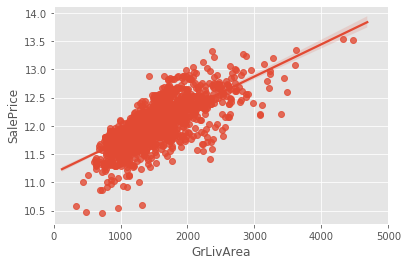

In [11]:
# Plotting to see the outlier effect:
sns.regplot(x='GrLivArea',y='SalePrice',data=df_train_cleaned)
plt.xlim(0,5000)

In [12]:
df_train_cleaned.to_csv('df_train_cleaned.csv')
df_test_cleaned.to_csv('df_test_cleaned.csv')
df_total_cleaned.to_csv('df_total_cleaned.csv')